In [1]:
import cv2 as cv
import glob
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from utils.batch_generator import BatchGenerator

In [3]:
from keras.models import Model
from keras.layers import Input, concatenate, Convolution2D, MaxPooling2D, UpSampling2D,Lambda
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K

Using TensorFlow backend.


In [4]:
DATA_DIR = '/Users/matt/masters_thesis/resized_data/'
BATCH_SIZE = 32

In [5]:
batch_gen = BatchGenerator(data_dir=DATA_DIR, batch_size=BATCH_SIZE)

In [6]:
batch_gen.load_data()

In [7]:
sample_x, sample_y = next(batch_gen.train_batches)

In [8]:
idx = np.random.randint(BATCH_SIZE, size=9)
images = sample_x[idx]
masks = sample_y[idx]

(-0.5, 223.5, 223.5, -0.5)

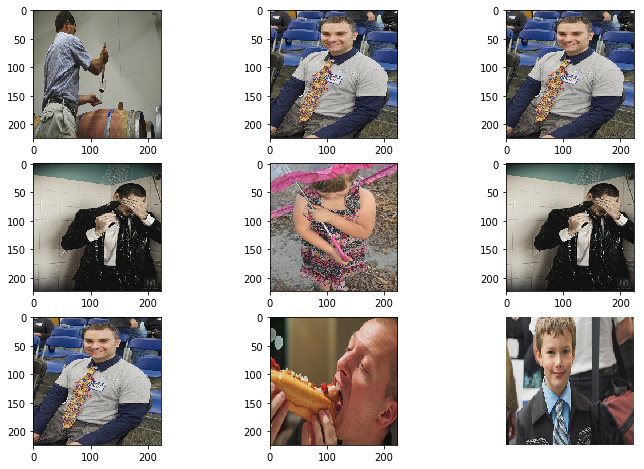

In [9]:
plt.figure(figsize=(12,8))
for pos in range(1, 10):
    plt.subplot(3, 3, pos)
    plt.imshow(images[pos - 1].astype(np.uint8))
plt.axis('off')

(-0.5, 223.5, 223.5, -0.5)

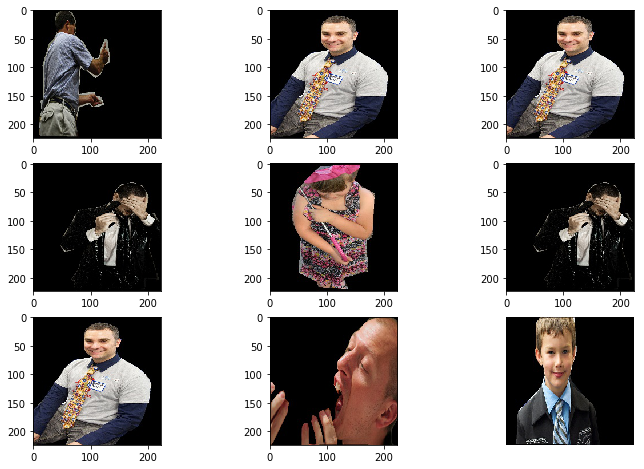

In [10]:
plt.figure(figsize=(12,8))
for pos in range(1, 10):
    plt.subplot(3, 3, pos)
    plt.imshow(masks[pos - 1].astype(np.uint8), cmap='gray')
plt.axis('off')

In [11]:
smooth = 1.
def IOU_calc(y_true, y_false):
    y_true_f = K.flatten(y_true)
    y_false_f = K.flatten(y_false)
    intersection = K.sum(y_true_f * y_false_f)
    return 2*(intersection + smooth) / (K.sum(y_true_f) + K.sum(y_false_f) + smooth)

def IOU_loss(y_true, y_false):
    return -1 * IOU_calc(y_true, y_false)
    

In [12]:
def unet_prototype(img_rows, img_cols):
    inputs = Input(shape=(img_rows, img_cols, 3))
    
    conv1 = Convolution2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(inputs)
    conv1 = Convolution2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    conv2 = Convolution2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(pool1)
    conv2 = Convolution2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    
    conv3 = Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(pool2)
    conv3 = Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Convolution2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(pool3)
    conv4 = Convolution2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    conv5 = Convolution2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(pool4)
    conv5 = Convolution2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same')(conv5)
    
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Convolution2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(up6)
    conv6 = Convolution2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(conv6)
    
    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(up7)
    conv7 = Convolution2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same')(conv7)
    
    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Convolution2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(up8)
    conv8 = Convolution2D(filters=16, kernel_size=(3, 3), activation='relu', padding='same')(conv8)
    
    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Convolution2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(up9)
    conv9 = Convolution2D(filters=8, kernel_size=(3, 3), activation='relu', padding='same')(conv9)
    
    conv10 = Convolution2D(filters=3, kernel_size=(1, 1), activation='sigmoid')(conv9)
    
    model = Model(inputs=inputs, outputs=conv10)
    
    return model

In [13]:
IMG_ROWS, IMG_COLS = 224, 224

In [14]:
batch_gen = BatchGenerator(data_dir=DATA_DIR)
batch_gen.load_data()
model = unet_prototype(IMG_ROWS, IMG_COLS)
model.compile(optimizer=Adam(lr=1e-4), loss=IOU_loss, metrics=[IOU_calc])

In [15]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 224, 224, 8)   224         input_1[0][0]                    
____________________________________________________________________________________________________
conv2d_2 (Conv2D)                (None, 224, 224, 8)   584         conv2d_1[0][0]                   
____________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)   (None, 112, 112, 8)   0           conv2d_2[0][0]                   
___________________________________________________________________________________________

In [16]:
#model.fit(*batch_gen.train_batches)
model.fit_generator(batch_gen.train_batches, steps_per_epoch=1e3, epochs=1)#(batch_gen.train_batches, samples_per_epoch=1000, nb_epoch=1)

Epoch 1/1
 340/1000 [=========>....................] - ETA: 316s - loss: -1.8272 - IOU_calc: 1.8272

KeyboardInterrupt: 